In [1]:
import pandas as pd
import numpy as np
import pm4py
from matplotlib import pyplot as plt
import seaborn as sns
from fitter import Fitter
import scipy.stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set()

### Importazione dataset

In [2]:
df_traces = pd.read_csv('C:/Users/HP/Desktop/df_traces_from_weigh.csv')
df_traces.drop('Unnamed: 0', axis=1, inplace=True)

df_t_est = pd.read_csv('C:/Users/HP/Desktop/df_t_est.csv')
df_t_est.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
event_log = df_traces[['ID', 'stato', 'ubicazione', 'rif', 'ID_unique', 'timestamp']]
event_log.sort_values(['ID', 'timestamp'], inplace=True)
event_log.reset_index(inplace=True, drop=True)

In [4]:
len(event_log['ID_unique'].unique())

1736

In [6]:
#  format event log and visualize working hours
event_log = df_traces[['ID', 'stato', 'ubicazione', 'rif', 'ID_unique', 'timestamp']]
event_log.sort_values(['ID', 'timestamp'], inplace=True)
event_log.reset_index(inplace=True, drop=True)
event_log = pm4py.format_dataframe(event_log, case_id='ID_unique', activity_key='rif', timestamp_key='timestamp')
h = 0
for x in range(23, 31):
    h += (len(event_log[event_log['timestamp'].dt.day == x]['timestamp'].dt.hour.unique()))
for x in range(1, 26):
    h += (len(event_log[event_log['timestamp'].dt.day == x]['timestamp'].dt.hour.unique()))
print('Ore di lavoro totali nell event log: ', h)

Ore di lavoro totali nell event log:  620


### Pre processing

In [7]:
#  remove traces with 'recheck' as activity
mask_recheck = np.asarray( event_log[ event_log['stato'] == 'P_recheck' ].index )
ID_recheck = event_log.loc[mask_recheck]['ID_unique'].values
mask_drop_recheck = np.asarray( event_log[ event_log['ID_unique'].isin(ID_recheck)].index )
event_log.drop( mask_drop_recheck, inplace = True )

#  visualize start/end activities
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'V_da_pes/pesatura': 1684, 'Not_def/fuori_impianto': 11, 'V_per_park/catenaria_parcheggi': 5, 'P_da_est/estrusore': 2, 'V_da_pes/catenaria_ing_misc': 1, 'P_da_est/fuori_impianto': 1, 'P_da_misc/fuori_impianto': 1}
End activities: {'V_per_park/estrusore': 1074, 'Not_def/fuori_impianto': 449, 'V_da_pes/estrusore': 173, 'P_da_est/estrusore': 3, 'V_da_pes/pesatura': 2, 'V_da_pes/navetta_serv_misc': 1, 'P_da_est/fuori_impianto': 1, 'P_da_misc/fuori_impianto': 1, 'V_da_pes/catenaria_ing_misc': 1}


In [8]:
#  filtering event log by start activiy
from pm4py.algo.filtering.pandas.start_activities import start_activities_filter
event_log = start_activities_filter.apply(event_log, ['V_da_pes/pesatura'],
                                          parameters={start_activities_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      start_activities_filter.Parameters.ACTIVITY_KEY: "concept:name"})
pm4py.get_start_activities(event_log)

{'V_da_pes/pesatura': 1684}

In [9]:
#  filtering event log by end activiy
from pm4py.algo.filtering.pandas.end_activities import end_activities_filter
event_log = end_activities_filter.apply(event_log, ['V_per_park/estrusore', 'Not_def/fuori_impianto', 'V_da_pes/estrusore'],
                                          parameters={end_activities_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      end_activities_filter.Parameters.ACTIVITY_KEY: "concept:name"})
pm4py.get_end_activities(event_log)

{'V_per_park/estrusore': 1071,
 'Not_def/fuori_impianto': 435,
 'V_da_pes/estrusore': 173}

In [10]:
#  fitering event log removing reworked traces
df_rework = pm4py.filter_activities_rework(event_log, "V_da_pes/catenaria_ing_misc", 2)
event_log.drop( df_rework.index, inplace = True )

### Process mining

In [11]:
#  evaluate number of variants
from pm4py.statistics.traces.generic.pandas import case_statistics
variants_count = case_statistics.get_variant_statistics(event_log,
                                          parameters={case_statistics.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      case_statistics.Parameters.ACTIVITY_KEY: "concept:name",
                                                      case_statistics.Parameters.TIMESTAMP_KEY: "time:timestamp"})
variants_count = sorted(variants_count, key=lambda x: x['case:concept:name'], reverse=True)
len(variants_count)

305

In [12]:
variants_count

[{'variant': 'V_da_pes/pesatura,P_da_misc/navetta_serv_misc,P_da_misc/miscelatore,P_remove/ing_zona_misc,Not_def/fuori_impianto',
  'case:concept:name': 118},
 {'variant': 'V_da_pes/pesatura,P_da_misc/navetta_serv_misc,P_da_misc/miscelatore,P_da_est/cat_usc_pieni,P_da_est/nav_serv_carr_pieni,P_da_est/carroponte_1,P_da_est/estrusore,V_per_park/estrusore',
  'case:concept:name': 113},
 {'variant': 'V_da_pes/pesatura,P_da_misc/navetta_serv_misc,P_da_misc/miscelatore,P_da_est/navetta_serv_misc,P_da_est/cat_usc_pieni,P_da_est/nav_serv_carr_pieni,P_da_est/carroponte_1,P_da_est/estrusore,V_per_park/estrusore',
  'case:concept:name': 105},
 {'variant': 'V_da_pes/pesatura,P_da_misc/navetta_serv_misc,P_da_misc/miscelatore,Not_def/fuori_impianto',
  'case:concept:name': 99},
 {'variant': 'V_da_pes/pesatura,P_da_misc/navetta_serv_misc,P_da_misc/miscelatore,P_da_est/navetta_serv_misc,P_da_est/cat_usc_pieni,P_da_est/nav_serv_carr_pieni,P_da_est/carroponte_1,P_da_est/buffer,P_da_est/carroponte_2,P_da

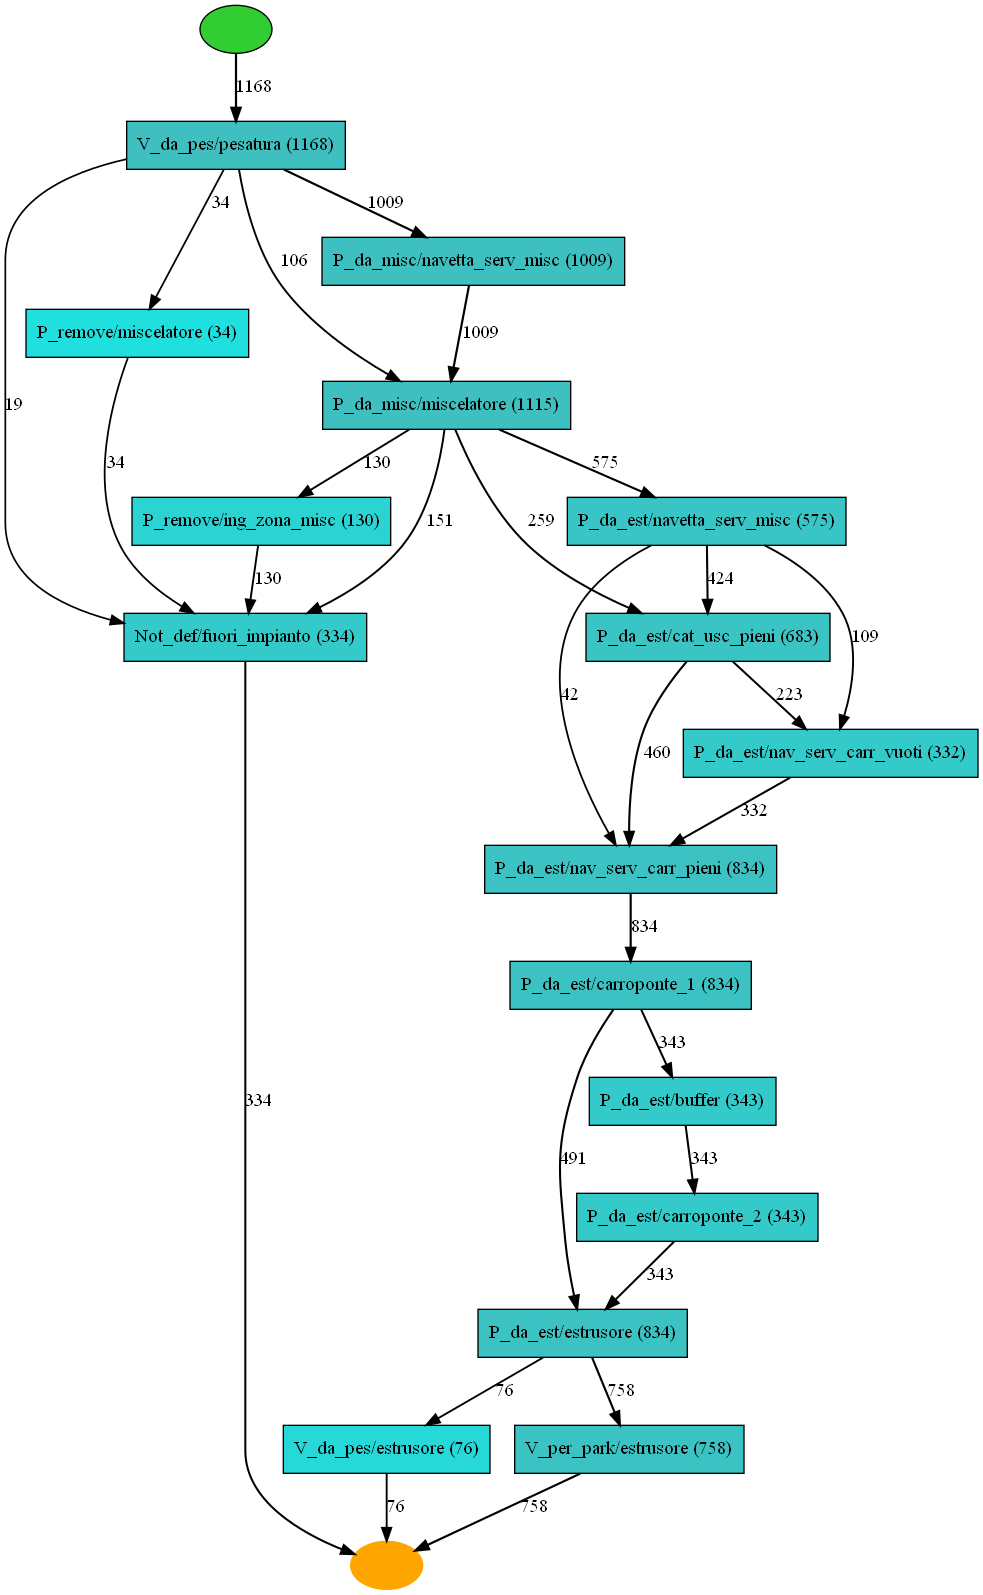

In [32]:
#  take most significant variants
filtered_log = pm4py.filter_variants_top_k(event_log, 25)

#  visualize heuristic net
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
heu_net = heuristics_miner.apply_heu(filtered_log,
                                     parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_ACT_COUNT: 1,
                                                heuristics_miner.Variants.CLASSIC.value.Parameters.MIN_DFG_OCCURRENCES: 1,
                                                heuristics_miner.Variants.CLASSIC.value.Parameters.LOOP_LENGTH_TWO_THRESH: 2})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [33]:
pm4py.save_vis_heuristics_net(heu_net, 'C:/Users/HP/Desktop/huristicnet_post_pes.png')

### Calcolo intertempi tra le attività

In [34]:
delta_t_est = {'pesatura': [],
              'hand_to_misc': [],
              'miscelazione': [],
              'hand_to_est':[],
              'estrusione': []}

df_est = filtered_log[['ID_unique', 'ubicazione', 'rif', 'timestamp']].copy()

In [35]:
for idu in df_est['ID_unique'].unique():
    mask = df_est['ID_unique'] == idu
    df_tmp = df_est[mask].sort_values('timestamp')
    df_tmp.set_index('rif', inplace=True)
    if len(df_tmp) == len(df_tmp.index.unique()):
        for k in delta_t_est:
            minuendo = None
            sottraendo = None
            if k == 'pesatura':
                if 'P_da_misc/navetta_serv_misc' in df_tmp.index:
                    minuendo = 'P_da_misc/navetta_serv_misc'
                    sottraendo = 'V_da_pes/pesatura'
                else:
                    continue
                #-----------
            elif k == 'hand_to_misc':
                if 'P_da_misc/navetta_serv_misc' in df_tmp.index:
                    minuendo = 'P_da_misc/miscelatore'
                    sottraendo = 'P_da_misc/navetta_serv_misc'
                else:
                    continue
                #-----------
            elif k == 'miscelazione':
                if 'Not_def/fuori_impianto' in df_tmp.index:
                    if 'P_remove/ing_zona_misc' in df_tmp.index:
                        minuendo = 'P_remove/ing_zona_misc'
                        sottraendo = 'P_da_misc/miscelatore'
                    elif 'P_remove/navetta_serv_misc' in df_tmp.index:
                        minuendo = 'P_remove/navetta_serv_misc'
                        sottraendo = 'P_da_misc/miscelatore'
                    else:
                        minuendo = 'Not_def/fuori_impianto'
                        sottraendo = 'P_da_misc/miscelatore'
                else:
                    if 'P_da_est/navetta_serv_misc' in df_tmp.index:
                        minuendo = 'P_da_est/navetta_serv_misc'
                        sottraendo = 'P_da_misc/miscelatore'
                    else:
                        minuendo = 'P_da_est/cat_usc_pieni'
                        sottraendo = 'P_da_misc/miscelatore'
                #----------------
            elif k == 'hand_to_est':
                if 'P_da_est/buffer' in df_tmp.index and 'P_da_est/cat_usc_pieni' in df_tmp.index:
                    minuendo = 'P_da_est/buffer'
                    sottraendo = 'P_da_est/cat_usc_pieni'
                elif 'P_da_est/buffer' in df_tmp.index and 'P_da_est/navetta_serv_misc' in df_tmp.index:
                    minuendo = 'P_da_est/buffer'
                    sottraendo = 'P_da_est/navetta_serv_misc'
                elif 'P_da_est/estrusore' in df_tmp.index and 'P_da_est/cat_usc_pieni' in df_tmp.index and 'P_da_est/buffer' not in df_tmp.index:
                    minuendo = 'P_da_est/estrusore'
                    sottraendo = 'P_da_est/cat_usc_pieni'
                elif 'P_da_est/estrusore' in df_tmp.index and 'P_da_est/navetta_serv_misc' in df_tmp.index and 'P_da_est/buffer' not in df_tmp.index:
                    minuendo = 'P_da_est/estrusore'
                    sottraendo = 'P_da_est/navetta_serv_misc'
                # ------------------
            elif k == 'estrusione':
                if 'V_da_pes/estrusore' in df_tmp.index:
                    minuendo = 'V_da_pes/estrusore'
                    sottraendo = 'P_da_est/estrusore'
                else:
                    minuendo = 'V_per_park/estrusore'
                    sottraendo = 'P_da_est/estrusore'

            if minuendo in df_tmp.index and sottraendo in df_tmp.index:
                dt = np.round(
                    (df_tmp.loc[minuendo, 'timestamp'] - df_tmp.loc[sottraendo, 'timestamp']).total_seconds() / 60, 4)
                delta_t_est[k].append(dt)

In [36]:
df_dt = pd.DataFrame.from_dict(delta_t_est, orient='index').transpose()

In [37]:
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pesatura      1009 non-null   float64
 1   hand_to_misc  1009 non-null   float64
 2   miscelazione  1115 non-null   float64
 3   hand_to_est   834 non-null    float64
 4   estrusione    834 non-null    float64
dtypes: float64(5)
memory usage: 43.7 KB


### Data visualization

In [38]:
def quantile(column,pct,pct_lower):
    y = column
    y.dropna(inplace=True)
    y = y.values
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    return (y)

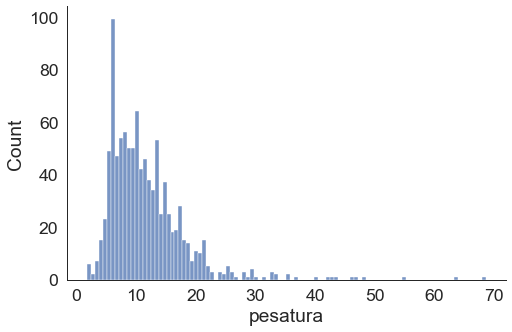

In [40]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="pesatura", kind="hist", bins = 100, aspect = 1.5)

In [41]:
np.mean(quantile(df_dt['pesatura'], 0.99, 0))

11.236188577154309

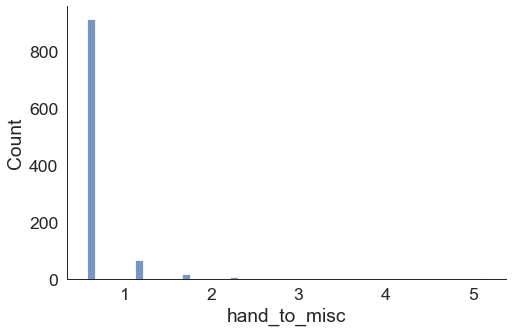

In [42]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="hand_to_misc", kind="hist", bins = 50, aspect = 1.5)

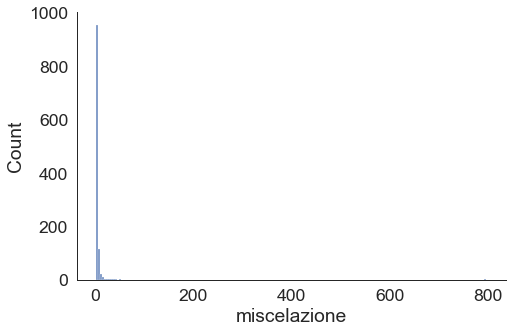

In [46]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="miscelazione", kind="hist", bins = 200, aspect = 1.5)

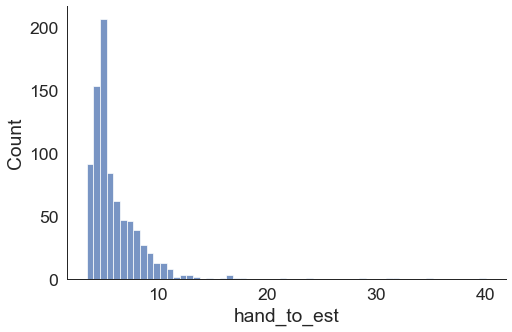

In [47]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=df_dt, x="hand_to_est", kind="hist", bins = 60, aspect = 1.5)

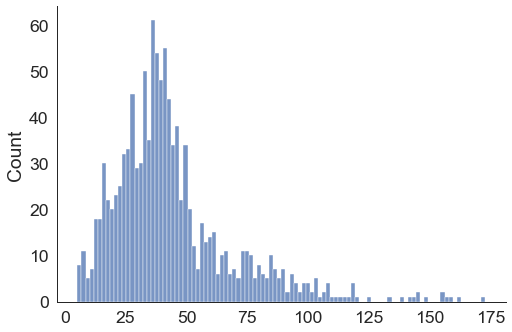

In [49]:
ns = pd.concat([df_dt['estrusione'], df_t_est['est_time']], ignore_index=True)
dt_est = quantile(ns, 0.99, 0.01)
sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=dt_est, kind="hist", bins = 100, aspect = 1.5)

### Fitting distributions to data

,sumsquare_error,aic,bic,kl_div
laplace_asymmetric,0.006824,1300.096460,-11990.394459,inf
exponnorm,0.008571,1344.556818,-11760.446644,inf
moyal,0.008597,1435.610156,-11764.289478,inf
gumbel_r,0.010105,1582.903752,-11601.226625,inf
rayleigh,0.014307,2189.424172,-11250.385680,inf


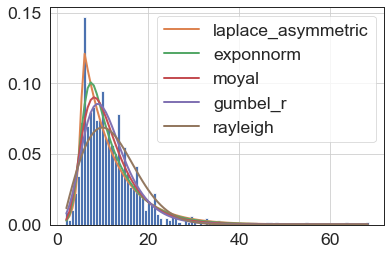

In [57]:
#  extract best fitting distribution from 'pesatura'
#data = quantile(df_dt['pesatura'], 0.99, 0.01)
data = df_dt['pesatura']
data.dropna(inplace=True)
data = data.values
f = Fitter(data)
f.fit()
f.summary()

In [58]:
f.get_best(method = 'sumsquare_error')

{'laplace_asymmetric': {'kappa': 0.37641766232483176,
  'loc': 5.716699996344049,
  'scale': 2.599112203088751}}

,sumsquare_error,aic,bic,kl_div
gumbel_r,0.000005,41646.672321,-21388.343531,inf
laplace_asymmetric,0.000050,31392.584955,-18837.603885,inf
logistic,0.000195,44769.973507,-17336.374113,inf
hypsecant,0.000405,41400.507267,-16520.154886,inf
expon,0.000887,24072.290953,-15645.275121,inf


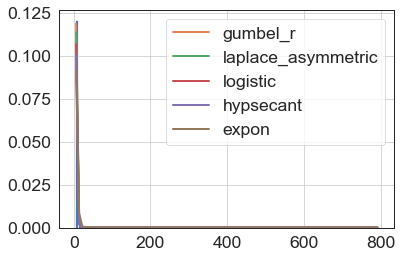

In [59]:
#  extract best fitting distribution from 'miscelazione'
# data = quantile(df_dt['miscelazione'], 0.99, 0.01)
data = df_dt['miscelazione']
data.dropna(inplace=True)
data = data.values
f = Fitter(data)
f.fit()
f.summary()

In [60]:
f.get_best(method = 'sumsquare_error')

{'gumbel_r': {'loc': 4.0226557176669395, 'scale': 1.9032955898103232}}

,sumsquare_error,aic,bic,kl_div
laplace_asymmetric,0.358767,1866.457688,-6444.419101,inf
cauchy,0.373895,1277.710430,-6416.698821,inf
laplace,0.391243,2387.124946,-6378.874889,inf
wald,0.424412,1278.868012,-6311.006132,inf
gumbel_r,0.438426,2465.053639,-6283.912447,inf


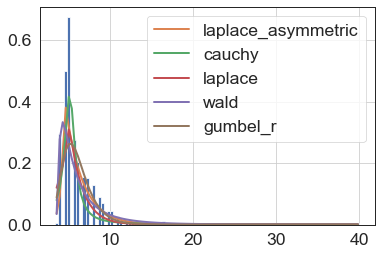

In [61]:
#  extract best fitting distribution from 'handling to estrusore'
#  data = quantile(df_dt['hand_to_est'], 0.99, 0.01)
data = df_dt['hand_to_est']
data.dropna(inplace=True)
data = data.values
f = Fitter(data)
f.fit()
f.summary()

In [62]:
f.get_best(method = 'sumsquare_error')

{'laplace_asymmetric': {'kappa': 0.43519883973980045,
  'loc': 4.5667000812755285,
  'scale': 0.8946508376109235}}

,sumsquare_error,aic,bic,kl_div
laplace,0.000630,1375.181199,-16088.520735,inf
cauchy,0.000680,1287.885065,-16003.373921,inf
gumbel_r,0.000874,1316.282377,-15722.092288,inf
laplace_asymmetric,0.001043,1268.670687,-15516.737658,inf
logistic,0.001195,1441.768398,-15372.013235,inf


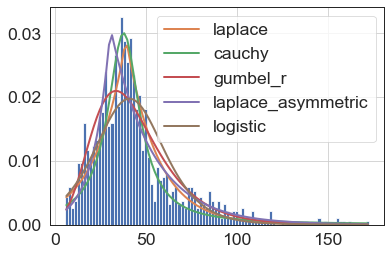

In [63]:
#  extract best fitting distribution from 'estrusione'
f = Fitter(dt_est)
f.fit()
f.summary()

In [64]:
f.get_best(method = 'sumsquare_error')

{'laplace': {'loc': 38.9, 'scale': 17.125572832886505}}

### Tempo totale di attraversamento

In [72]:
def quantile2(column,pct,pct_lower):
    y = column
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    return y

In [73]:
def filtering(event_log, ubicazione):
    mask = event_log['ubicazione'] == ubicazione
    get_ID = event_log[mask]['ID_unique'].unique()
    mask_id = event_log['ID_unique'].isin(get_ID)
    new_log = event_log[mask_id]
    return(new_log)

In [118]:
df_est = filtering(df_est, 'estrusore')

tc_list = []
for idu in df_est['ID_unique'].unique():
    mask = df_est['ID_unique'] == idu
    df_tmp = df_est[mask].sort_values('timestamp')
    df_tmp.reset_index(drop=True, inplace=True)
    t1 = df_tmp.loc[0, 'timestamp']
    t2 = df_tmp.loc[len(df_tmp) - 1, 'timestamp']
    tc = ((t2 - t1).seconds)/60
    tc_list.append(tc)

In [119]:
df_tc_sim = pd.read_csv('C:/Users/HP/Desktop/df_tc_sim.csv')

In [120]:
tc_sim = list(df_tc_sim['t_tot'])

In [121]:
len(tc_sim)

1009

In [122]:
tc_list = quantile2(tc_list, 0.98, 0)
tc_list = [x + 2.85 for x in tc_list]
len(tc_list)

373

In [123]:
tc_sim = tc_sim[(len(tc_sim) - (len(tc_list))):]
len(tc_sim)

373

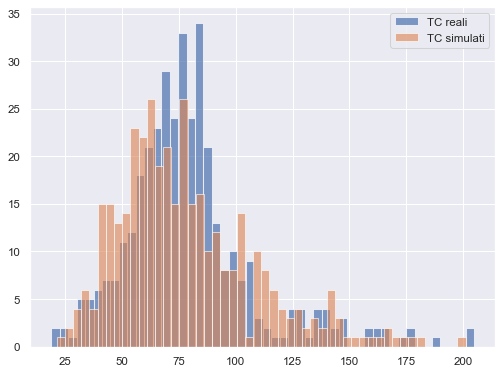

In [130]:
plt.figure(figsize=(8, 6), dpi=75)
plt.hist(tc_list, 50, alpha=0.7, label='TC reali')
plt.hist(tc_sim, 50, alpha=0.6, label='TC simulati')
plt.legend(loc='upper right')
plt.savefig('C:/Users/HP/Desktop/dist_real_sim.png')
plt.show()

In [125]:
from sklearn.metrics import mean_squared_error
  
# Calculation of Root Mean Squared Error (RMSE)
np.sqrt(mean_squared_error(sorted(tc_list),sorted(tc_sim)))

5.240624642298263

In [127]:
mean_real = np.round(np.mean(tc_list), 2)
mean_sim = np.round(np.mean(tc_sim), 2)
print('Media delle osservazioni reali: {}\nMedia delle osservazioni simulate: {}'.format(mean_real, mean_sim))
print('')
mean_real = np.round(np.median(tc_list), 2)
mean_sim = np.round(np.median(tc_sim), 2)
print('Mediana delle osservazioni reali: {}\nMediana delle osservazioni simulate: {}'.format(mean_real, mean_sim))

Media delle osservazioni reali: 79.77
Media delle osservazioni simulate: 78.15

Mediana delle osservazioni reali: 76.1
Mediana delle osservazioni simulate: 72.3
